## Use scaling for longer canyon

Using scaling and fitted functions from notebook scalling_tracer_flux_paper1_clean.ipynb, see if our scaling works when using a longer canyon.

L = 12800.0 m, vs 6400.0 m from Barkley-like run

R = 5000.0 m

Wm = 24432.4 m, Width at shelf break

W = 22044.8 m, mid-length width at rim depth

Ws = 13756.1 m, mid-length width at shelf-break isobath

Hs = 150.0 m,  Shelf break depth

s = 0.005 m, shelf slope 

Hh = 97.5 m, head depth

Hr = 132.0 m, rim depth at DnS

No = 5.5E-3 s$^{-1}$, Initial stratification at shelf-break depth

f = 9.66E-5 s$^{-1}$, Coriois parameter 

U = 0.344 ms$^{-1}$,  incoming velocity base case, m/s (from model)



In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.gridspec as gspec
from matplotlib.ticker import FormatStrFormatter
from netCDF4 import Dataset
import numpy as np
import os
import pandas as pd
import seaborn as sns
import sys
import scipy.stats
import warnings
warnings.filterwarnings("ignore")
import canyon_tools.readout_tools as rout 
import canyon_tools.metrics_tools as mpt

In [3]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')


In [4]:
sns.set_context('paper')
sns.set_style('white')

In [5]:
CanyonGrid='/data/kramosmu/results/TracerExperiments/CNTDIFF/run38/gridGlob.nc'
CanyonGridOut = Dataset(CanyonGrid)

CanyonGridNoC='/data/kramosmu/results/TracerExperiments/CNTDIFF/run68/gridGlob.nc'
CanyonGridOutNoC = Dataset(CanyonGridNoC)

CanyonState='/data/kramosmu/results/TracerExperiments/CNTDIFF/run38/stateGlob.nc'
CanyonStateOut = Dataset(CanyonState)

# Grid variables
nx = 616
ny = 360
nz = 90
nt = 19 # t dimension size 
time = CanyonStateOut.variables['T']
RC = CanyonGridOut.variables['RC']

In [6]:
# Constants and scales

L = 12800.0 # canyon length
R = 5000.0 # Upstream radius of curvature
g = 9.81 # accel. gravity
Hs = 149.8 # Shelf break depth
s = 0.005 # shelf slope
Wr = 13756.1 # mid-length width at shelf break isobath
W = 22044.8 # mid-length width at rim depth
Hh= 98.8 # head depth
Hr = 108.1 # rim depth at UwH

# NOTE: The default values of all functions correspond to the base case

def Dh(f=9.66E-4,L=6400.0,N=5.5E-3):
    '''Vertical scale Dh'''
    return((f*L)/(N))
    
def Ro(U=0.37,f=9.66E-4,R=5000.0):
    '''Rossby number using radius of curvature as length scale'''
    return(U/(f*R))

def F(Ro):
    '''Function that estimates the ability of the flow to follow isobaths'''
    return(Ro/(0.9+Ro))

def Bu(N=5.5E-3,f=9.66E-5,W=8300,Hs=150.0):
    '''Burger number'''
    return(N*Hs/(f*W))

def RossbyRad(N=5.5E-3,Hs=150.0,f=9.66E-4):
    '''1st Rossby radius of deformation'''
    return(N*Hs/f)

In [7]:
# Information for all runs is stored in canyon_records.py
lib_path = os.path.abspath('/ocean/kramosmu/OutputAnalysis/outputanalysisnotebooks/PythonScripts/Paper1Figures/') # Add absolute path to my python scripts
sys.path.append(lib_path)

import canyon_records 
records = canyon_records.main()

import nocanyon_records 
recordsNoC = nocanyon_records.main()

### Not all runs are used to fit all variables

**records_dyn** has all runs where f, N or U vary. USe this list to fit upwelling flux $\Phi$ and modify *Howatt and Allen 2013*.

**records_epsilon** has all runs in records_dyn plus the runs with a heaviside Kv profile. Use this list to fit $\Phi$ with scaled N.

**records_real** has all runs in records_epsilon plus the runs with a Kv profile inspired in observations.

In [16]:
for rec in records_real:

    Dz = abs(RC[int(Hrim/5)+1]-RC[int(Hrim/5)-1])
    rec.Z = ((rec.f*rec.u_mod*F(Ro(rec.u_mod,rec.f,R))*L)**(0.5))/rec.N
    
    if rec.kv == rec.kbg:
        rec.Zdif = 0
        rec.Sdif_min = np.exp(-0.15*rec.Zdif/Dz) # -0.1 comes from the 1D model
        rec.dk = 0
        rec.Kz = 1E-5
        rec.Kz_be = 1E-5
        rec.Sdif_max = (rec.Zdif/Dz)*np.exp(-(rec.Kz*t*3600*24)/((rec.epsilon)**2))
    
    else:
        rec.Sdif_min = np.exp(-0.15*rec.Zdif/Dz)
        rec.Sdif_max = (rec.Zdif/Dz)*np.exp(-(rec.Kz*t*3600*24)/((rec.epsilon)**2))
        
    rec.S_max = (rec.Z/Hh)*np.exp(-rec.Kz*t*3600*24/rec.Z**2)
    rec.S_min = (rec.Z/Hh)*np.exp(-rec.Kz_be*t*3600*24/rec.Z**2)

In [17]:
X1_be = np.array([rec.S_min for rec in records_epsilon])
X2_be = np.array([rec.Sdif_min for rec in records_epsilon])
Y_be = np.array([(rec.Nbe)**2/(rec.N**2) for rec in records_epsilon])

X1_ab = np.array([rec.S_max for rec in records_epsilon])
X2_ab = np.array([rec.Sdif_max for rec in records_epsilon])
Y_ab = np.array([(rec.Nab)**2/(rec.N**2) for rec in records_epsilon])

min $N^2/N^2_0$ = 2.95 $S^-$ + 2.02 $S^-_{diff}$  -0.93 
max $N^2/N^2_0$ = 8.17 $S^+$ + 0.22 $S^+_{diff}$ + 0.81 


Using parameter 0.60: slope = 3.42, intercept = -0.015, r-value = 0.872
Using parameter 0.62: slope = 3.57, intercept = -0.016, r-value = 0.883
Using parameter 0.63: slope = 3.72, intercept = -0.017, r-value = 0.894
Using parameter 0.65: slope = 3.87, intercept = -0.018, r-value = 0.904
Using parameter 0.66: slope = 4.03, intercept = -0.019, r-value = 0.913
Using parameter 0.68: slope = 4.18, intercept = -0.020, r-value = 0.922
Using parameter 0.69: slope = 4.34, intercept = -0.020, r-value = 0.930
Using parameter 0.71: slope = 4.50, intercept = -0.021, r-value = 0.937
Using parameter 0.72: slope = 4.65, intercept = -0.021, r-value = 0.944
Using parameter 0.74: slope = 4.81, intercept = -0.021, r-value = 0.950
Using parameter 0.75: slope = 4.97, intercept = -0.021, r-value = 0.955
Using parameter 0.77: slope = 5.12, intercept = -0.020, r-value = 0.960
Using parameter 0.78: slope = 5.27, intercept = -0.020, r-value = 0.964
Using parameter 0.80: slope = 5.43, intercept = -0.020, r-value 

### Tracer gradient

min $dzC/dzCo$ = 3.81 $S^-$ + 1.35 $S^-_{diff}$  -0.73 
max $dzC/dzCo$ = 8.10 $S^+$ + 0.23 $S^+_{diff}$  0.81 


### Concentration

$\bar{C}/Co$ = 0.33 $S^+$ + 0.06 $S^+_{diff}$  1.01 


### Tracer flux

In [ ]:
Phi = 0.9*F()
phiTr = C*Phi - 442.22

In [26]:
Y_array = np.array([rec.PhiTr for rec in records_epsilon])
X_array = np.array([rec.RA2018*(rec.u_mod*W*Dh(rec.f,L,rec.N_eff_scaled))*
                    (rec.Tr_scaled) for rec in records_epsilon])
slope6, intercept6, r_value6, p_value6, std_err6 = scipy.stats.linregress(np.squeeze(X_array),
                                                                          np.squeeze(Y_array))
    
for rec in records_real:
    rec.Phi_scaled = rec.RA2018*(rec.u_mod*W*Dh(rec.f,L,rec.N_eff_scaled))
    rec.PhiTr_scaled = np.squeeze((slope6*rec.Phi_scaled*(rec.Tr_scaled))+intercept6)
    
print('\Phi/UWD_{eff} = %1.2f Fw^{3/2} Ro^{1/2} (1-%1.2f *Se)^3 +%1.2f' %(slope2,param2,intercept2))    
print('\Phi_{Tr} = %1.2f $\Phi \ bar{C}$ + %1.2f ' %(slope6, intercept6))    

\Phi/UWD_{eff} = 6.33 Fw^{3/2} Ro^{1/2} (1-0.89 *Se)^3 +-0.01
\Phi_{Tr} = 1.00 $\Phi \ bar{C}$ + -1094.69 


## Figures

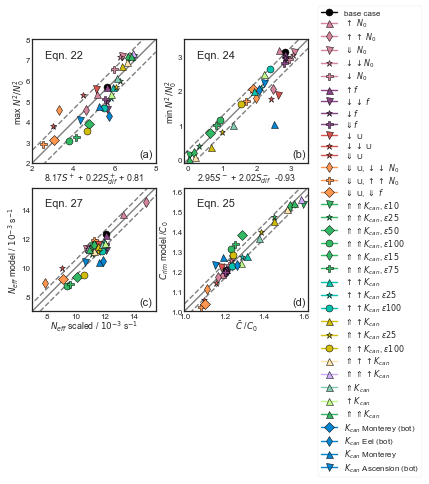

In [27]:
sns.set_context('paper')
plt.rcParams['font.size'] = 11.0
f = plt.figure(figsize = (5,5)) # 190mm = 7.48 in, 230cm = 9.05in

gs = gspec.GridSpec(2, 2,wspace=0.2)
ax1 = plt.subplot(gs[0,0])
ax0 = plt.subplot(gs[0,1])
ax3 = plt.subplot(gs[1,0])
ax2 = plt.subplot(gs[1,1])


# ---- plot 1:1 line ----
ax0.plot(np.linspace(-0.1,3.5,20),np.linspace(-0.1,3.5,20), '-',color='0.5')
ax1.plot(np.linspace(2,8,20),np.linspace(2,8,20), '-', color='0.5')
ax3.plot(np.linspace(5, 17, 20),np.linspace(5,17, 20),'-', color='0.5')
ax2.plot(np.linspace(1, 1.8, 20),np.linspace(1, 1.8, 20),'-', color='0.5')

# ---- plot error -----
# MSE ax0    
phi_array = np.array([(rec.Nbe_scaled/rec.N)**2 for rec in records_epsilon])
sca_array = np.array([(rec.Nbe)**2/(rec.N**2)  for rec in records_epsilon])
x_fit = np.linspace(-0.1, 3.5, 50)
mean_sq_err = np.nanmean(((phi_array)-(sca_array))**2)
upper_bound = ax0.plot(x_fit,x_fit+(mean_sq_err)**(0.5),linestyle = '--',color='0.5')
lower_bound = ax0.plot(x_fit,x_fit-(mean_sq_err)**(0.5),linestyle = '--',color='0.5')

# MSE ax1    
phi_array = np.array([(rec.Nab_scaled/rec.N)**2 for rec in records_epsilon])
sca_array = np.array([(rec.Nab)**2/(rec.N**2) for rec in records_epsilon])
x_fit = np.linspace(2,8, 50)
mean_sq_err = np.mean(((phi_array)-(sca_array))**2)
upper_bound = ax1.plot(x_fit,x_fit+(mean_sq_err)**(0.5),linestyle = '--',color='0.5')
lower_bound = ax1.plot(x_fit,x_fit-(mean_sq_err)**(0.5),linestyle = '--',color='0.5')

# MSE ax2    
phi_array = np.array([rec.N_eff_scaled/1E-3 for rec in records_epsilon])
sca_array = np.array([rec.Neff/1E-3 for rec in records_epsilon])
x_fit = np.linspace(5,17, 50)
mean_sq_err = np.mean(((phi_array)-(sca_array))**2)
upper_bound = ax3.plot(x_fit,x_fit+(mean_sq_err)**(0.5),linestyle = '--',color='0.5')
lower_bound = ax3.plot(x_fit,x_fit-(mean_sq_err)**(0.5),linestyle = '--',color='0.5')

# MSE ax3    
phi_array = np.squeeze(np.array([rec.Tr_scaled/rec.Tr0 for rec in records_epsilon]))
sca_array = np.squeeze(np.array([rec.Tr/rec.Tr0 for rec in records_epsilon]))
x_fit = np.linspace(1,1.8, 50)
mean_sq_err = np.mean(((phi_array)-(sca_array))**2)
upper_bound = ax2.plot(x_fit,x_fit+(mean_sq_err)**(0.5),linestyle = '--',color='0.5')
lower_bound = ax2.plot(x_fit,x_fit-(mean_sq_err)**(0.5),linestyle = '--',color='0.5')

# ---- plot scaling ----
for rec in records_real:
    
    plt0 = ax0.plot((rec.Nbe_scaled/rec.N)**2,(rec.Nbe)**2/(rec.N**2),
                    marker = rec.mstyle,
                    markersize = 7,
                    color = sns.xkcd_rgb[rec.color2],
                    markeredgewidth=0.5,
                    markeredgecolor = 'k',
                    label=rec.label2)
      
    plt1 = ax1.plot((rec.Nab_scaled/rec.N)**2,(rec.Nab)**2/(rec.N**2),
                    marker = rec.mstyle,
                    markersize = 7,
                    color = sns.xkcd_rgb[rec.color2],
                    markeredgewidth=0.5,
                    markeredgecolor = 'k',
                    label=rec.label2) 
    
    plt2 = ax3.plot(rec.N_eff_scaled/1E-3,rec.Neff/1E-3,
                    marker = rec.mstyle,
                    markersize = 7,
                    color = sns.xkcd_rgb[rec.color2],
                    markeredgewidth=0.5,
                    markeredgecolor = 'k',
                    label=rec.label2)
    plt3 = ax2.plot(rec.Tr_scaled/rec.Tr0,
                    (rec.Tr/rec.Tr0),
                     marker = rec.mstyle,
                     markersize = 7,
                     color = sns.xkcd_rgb[rec.color2],
                     markeredgewidth=0.5,
                     markeredgecolor = 'k',
                     label=rec.label2)

    
    
# ---- aesthetics -----
ax0.set_xlim(-0.1,3.5)
ax0.set_ylim(-0.1,3.5)

ax1.set_xlim(2,8)
ax1.set_ylim(2,8)

ax3.set_xlim(7,15.5)
ax3.set_ylim(7,15.5)

ax2.set_xlim(1,1.62)
ax2.set_ylim(1,1.62)


ax0.set_ylabel('min $N^2/N^2_0$',labelpad=-1.5)
ax1.set_ylabel('max $N^2/N^2_0$',labelpad=-1.5)
ax0.set_xlabel(r'%1.2f$S^-$ + %1.2f$S^-_{dif}$  %1.2f' %(reg_be.coef_[0], 
                                                         reg_be.coef_[1], 
                                                         reg_be.intercept_),labelpad=0.5)
ax1.set_xlabel(r'%1.2f$S^+$ + %1.2f$S^+_{dif}$ + %1.2f' %(reg_ab.coef_[0], 
                                                          reg_ab.coef_[1], 
                                                          reg_ab.intercept_),labelpad=0.5)

ax3.set_ylabel('$N_{eff}$ model / $10^{-3}$ s$^{-1}$', labelpad=0)
ax3.set_xlabel('$N_{eff}$ scaled / $10^{-3}$ s$^{-1}$',labelpad=0.0)
ax2.set_ylabel(r'$C_{rim}$ model /$C_0$', labelpad=0)
ax2.set_xlabel(r'$\bar{C}$ /$C_0$', labelpad=0.0)

ax0.tick_params(axis='x', pad=2)
ax1.tick_params(axis='x', pad=2)
ax3.tick_params(axis='x', pad=2)
ax2.tick_params(axis='x', pad=2)

ax0.tick_params(axis='y', pad=2)
ax1.tick_params(axis='y', pad=2)
ax3.tick_params(axis='y', pad=2)
ax2.tick_params(axis='y', pad=2)

ax0.legend(bbox_to_anchor=(1.05,1.3), ncol=1,columnspacing=0.1,labelspacing=0.1,frameon=True )

ax0.set_aspect(1)
ax1.set_aspect(1)
ax2.set_aspect(1)
ax3.set_aspect(1)

ax1.text(0.1,0.85,'Eqn. 22',transform=ax1.transAxes)
ax0.text(0.1,0.85,'Eqn. 24',transform=ax0.transAxes)
ax3.text(0.1,0.85,'Eqn. 27',transform=ax3.transAxes)
ax2.text(0.1,0.85,'Eqn. 25',transform=ax2.transAxes)

ax1.text(0.87,0.05,'(a)',transform=ax1.transAxes)
ax0.text(0.87,0.05,'(b)',transform=ax0.transAxes)
ax3.text(0.87,0.05,'(c)',transform=ax3.transAxes)
ax2.text(0.87,0.05,'(d)',transform=ax2.transAxes)

plt.savefig('figure10_v2.eps',format='eps',bbox_inches='tight')


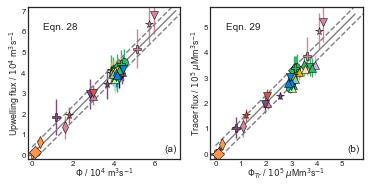

In [28]:
sns.set_context('paper')
plt.rcParams['font.size'] = 10.0
f = plt.figure(figsize = (6,3)) # 190mm = 7.48 in, 230cm = 9.05in

gs = gspec.GridSpec(1, 2)
ax0 = plt.subplot(gs[0,0])
ax1 = plt.subplot(gs[0,1])

# ---- plot 1:1 lines ----
ax0.plot(np.linspace(0,7,50),np.linspace(0,7,50),'-', color='0.5')
ax1.plot(np.linspace(0,5.5,50),np.linspace(0,5.5,50),'-', color='0.5')

# ---- plot errors ----
# MSE ax0    
phi_array = np.array([rec.Phi/1E4 for rec in records_dyn])
sca_array = np.array([rec.Phi_scaled/1E4  for rec in records_dyn])
x_fit = np.linspace(0,8, 50)
mean_sq_err = np.mean(((phi_array)-(sca_array))**2)
upper_bound = ax0.plot(x_fit,x_fit+(mean_sq_err)**(0.5),linestyle = '--',color='0.5')
lower_bound = ax0.plot(x_fit,x_fit-(mean_sq_err)**(0.5),linestyle = '--',color='0.5')

# MSE ax1    
phi_array = np.array([rec.PhiTr_scaled/1E5 for rec in records_epsilon])
sca_array = np.array([rec.PhiTr/1E5 for rec in records_epsilon])
x_fit = np.linspace(0,6, 50)
mean_sq_err = np.mean(((phi_array)-(sca_array))**2)
upper_bound = ax1.plot(x_fit,x_fit+(mean_sq_err)**(0.5),linestyle = '--',color='0.5')
lower_bound = ax1.plot(x_fit,x_fit-(mean_sq_err)**(0.5),linestyle = '--',color='0.5')

# ---- plot scaling ----
for rec in records_real:
    
    plt1 = ax0.errorbar(rec.Phi_scaled/1E4,
                        rec.Phi/1E4,
                        yerr=rec.Phi_std/1E4,
                        marker = rec.mstyle,
                        markersize = 8,
                        color = sns.xkcd_rgb[rec.color2],
                        markeredgewidth=0.5,
                        markeredgecolor = 'k',
                        label=rec.label2)
    plt1 = ax1.errorbar(rec.PhiTr_scaled/1E5,
                        rec.PhiTr/1E5,
                        yerr=rec.PhiTr_std/1E5,
                        marker = rec.mstyle,
                        markersize = 8,
                        color = sns.xkcd_rgb[rec.color2],
                        markeredgewidth=0.5,
                        markeredgecolor = 'k',
                        label=rec.label2)


# ---- aesthetics ----
ax0.set_ylabel('Phi',labelpad=0.5)
ax0.set_ylabel('Upwelling flux / $10^4$ m$^3$s$^{-1}$', labelpad=-0.5)
ax1.set_ylabel('Tracer flux / $10^5$ $\mu$Mm$^3$s$^{-1}$', labelpad=-0.5)

ax0.set_xlabel(r'$\Phi$ / $10^4$ m$^3$s$^{-1}$', labelpad=-0.5 )
ax1.set_xlabel(r'$\Phi_{Tr}$ / $10^5$ $\mu$Mm$^3$s$^{-1}$', labelpad=-0.5)

ax0.set_xlim(-0.2,7.2)
ax0.set_ylim(-0.2,7.2)

ax1.set_xlim(-0.2,5.8)
ax1.set_ylim(-0.2,5.8)

ax0.text(0.1,0.85,'Eqn. 28',transform=ax0.transAxes)
ax1.text(0.1,0.85,'Eqn. 29',transform=ax1.transAxes)

ax0.text(0.9,0.05,'(a)',transform=ax0.transAxes)
ax1.text(0.9,0.05,'(b)',transform=ax1.transAxes)

ax0.tick_params(axis='x', pad=2)
ax1.tick_params(axis='x', pad=2)

ax0.tick_params(axis='y', pad=2)
ax1.tick_params(axis='y', pad=2)

ax0.set_aspect(1)
ax1.set_aspect(1)

plt.savefig('figure11_v2.eps',format='eps',bbox_inches='tight')


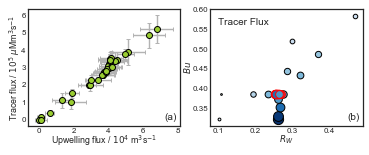

In [42]:
sns.set_context('paper')
sns.set_style("white")
plt.rcParams['font.size'] = 10.0
f = plt.figure(figsize = (6,3)) # 190mm = 7.48 in, 230cm = 9.05in

gs = gspec.GridSpec(1, 2)
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])

# ---- plot scaling ----
for rec in records_real:
    
    plt1 = ax0.errorbar(rec.Phi/1E4,
                        rec.PhiTr/1E5,
                        yerr=rec.PhiTr_std/1E5,
                        xerr = rec.Phi_std/1E4,
                        marker = '.',
                        markersize = 12,
                        color = 'yellowgreen',
                        markeredgewidth=1,
                        markeredgecolor = 'k',
                        label=rec.label2,
                        capsize=2,
                        ecolor = '0.7')
    if rec.kv <= 1E-5:
        plt1 = ax1.scatter(Ro(U=rec.u_mod, f=rec.f, R=Wr),
                           Bu(rec.N, rec.f,W,Hs),
                           c = rec.PhiTr/1E5,
                           vmin=0, vmax=5,
                           cmap='Blues',
                           marker = 'o',
                           s = (rec.PhiTr/1E5)*20,
                           linewidths=1,
                           edgecolors='k',
                           )
    else:
        plt1 = ax1.scatter(Ro(U=rec.u_mod, f=rec.f, R=Wr),
                           Bu(rec.N, rec.f,W,Hs),
                           c = rec.PhiTr/1E5,
                           vmin=0, vmax=5,
                           cmap='Blues',
                           marker = 'o',
                           s = (rec.PhiTr/1E5)*20,
                           linewidths=1,
                           edgecolors='r',
                           )
    

# ---- aesthetics ----
ax0.set_xlabel('Upwelling flux / $10^4$ m$^3$s$^{-1}$', labelpad=-0.5)
ax0.set_ylabel('Tracer flux / $10^5$ $\mu$Mm$^3$s$^{-1}$', labelpad=-0.5)

ax1.set_xlabel('$R_W$', labelpad=-0.5)
ax1.set_ylabel('$Bu$', labelpad=-0.5)

#ax0.set_xlim(-0.2,7.2)
#ax0.set_ylim(-0.2,7.2)

ax0.tick_params(axis='x', pad=2)
ax0.tick_params(axis='y', pad=2)

ax1.tick_params(axis='x', pad=2)
ax1.tick_params(axis='y', pad=2)

ax0.set_aspect(1)
ax1.set_aspect(1.07)

ax1.text(0.1,0.56,'Tracer Flux')
ax0.text(0.9,0.05,'(a)',transform=ax0.transAxes)
ax1.text(0.9,0.05,'(b)',transform=ax1.transAxes)
plt.savefig('figure_fluxes_comparison.eps',format='eps',bbox_inches='tight')


### Tables

In [30]:
print ("\t".join(['Experiment &','$\kappa_{bg}$ &','$\kappa_{can}$&','$\epsilon$&',
                 ]))

    
for rec in records_sel:
     print ("\t".join(['%s\t&$%0.2e$\t&$%0.2e$\t&$%1.0f$ ' 
                      % (rec.label2,
                         rec.kbg,
                         rec.kv, 
                         rec.epsilon,
                         )
                       ]))

Experiment &	$\kappa_{bg}$ &	$\kappa_{can}$&	$\epsilon$&
base case	&$1.00e-05$	&$1.00e-05$	&$5$ 
$\uparrow$ $K_{bg}$	&$1.00e-04$	&$1.00e-04$	&$5$ 
$\uparrow \uparrow$ $K_{bg}$	&$1.00e-03$	&$1.00e-03$	&$5$ 
$\uparrow$ $N_0$	&$1.00e-05$	&$1.00e-05$	&$5$ 
$\uparrow \uparrow$ $N_0$	&$1.00e-05$	&$1.00e-05$	&$5$ 
$\Downarrow$ $N_0$	&$1.00e-05$	&$1.00e-05$	&$5$ 
$\downarrow \downarrow N_0$	&$1.00e-05$	&$1.00e-05$	&$5$ 
$\downarrow$ $N_0$	&$1.00e-05$	&$1.00e-05$	&$5$ 
$\uparrow f$	&$1.00e-05$	&$1.00e-05$	&$5$ 
$\downarrow \downarrow$ $f$	&$1.00e-05$	&$1.00e-05$	&$5$ 
$\downarrow f$	&$1.00e-05$	&$1.00e-05$	&$5$ 
$\Downarrow f$	&$1.00e-05$	&$1.00e-05$	&$5$ 
$\downarrow$ U	&$1.00e-05$	&$1.00e-05$	&$5$ 
$\downarrow \downarrow$ U	&$1.00e-05$	&$1.00e-05$	&$5$ 
$\Downarrow$ U	&$1.00e-05$	&$1.00e-05$	&$5$ 
$\Downarrow$ U, $\downarrow \downarrow$ $N_0$	&$1.00e-05$	&$1.00e-05$	&$5$ 
$\Downarrow$ U, $\uparrow \uparrow$ $N_0$	&$1.00e-05$	&$1.00e-05$	&$5$ 
$\Downarrow$ U, $\Downarrow$ $f$	&$1.00e-05$	&$1.0

In [34]:
print ("\t".join(['Experiment &', '$N$ (s$^{-1}$)$&', 
                  '$f$ (s$^{-1}$)&', 'U (ms$^{-1}$)&', '$Bu$&', '$Ro$' ,'$R_L$' ,'$R_W$' ,
                 ]))

    
for rec in records_sel:
     print ("\t".join(['%s\t\t&$%.1e$\t&$%.2e$\t&$%.2f$\t&$%.2f$\t&$%.2f$\t&$%.2f$\t&$%.2f$\t ' 
                      % (rec.label2, 
                         rec.N,
                         rec.f,
                         rec.u_mod,
                         Bu(rec.N, rec.f, W, Hs),
                         Ro(U=rec.u_mod, f=rec.f, R=R),
                         Ro(U=rec.u_mod, f=rec.f, R=L),
                         Ro(U=rec.u_mod, f=rec.f, R=Wr),
                         )
                       ]))

Experiment &	$N$ (s$^{-1}$)$&	$f$ (s$^{-1}$)&	U (ms$^{-1}$)&	$Bu$&	$Ro$	$R_L$	$R_W$
base case		&$5.5e-03$	&$9.66e-05$	&$0.36$	&$0.39$	&$0.76$	&$0.59$	&$0.27$	 
$\uparrow$ $K_{bg}$		&$5.5e-03$	&$9.66e-05$	&$0.36$	&$0.39$	&$0.75$	&$0.59$	&$0.27$	 
$\uparrow \uparrow$ $K_{bg}$		&$5.5e-03$	&$9.66e-05$	&$0.32$	&$0.39$	&$0.66$	&$0.52$	&$0.24$	 
$\uparrow$ $N_0$		&$6.3e-03$	&$9.66e-05$	&$0.38$	&$0.44$	&$0.78$	&$0.61$	&$0.29$	 
$\uparrow \uparrow$ $N_0$		&$7.4e-03$	&$9.66e-05$	&$0.40$	&$0.52$	&$0.82$	&$0.64$	&$0.30$	 
$\Downarrow$ $N_0$		&$4.6e-03$	&$9.66e-05$	&$0.35$	&$0.32$	&$0.72$	&$0.56$	&$0.26$	 
$\downarrow \downarrow N_0$		&$4.7e-03$	&$9.66e-05$	&$0.35$	&$0.33$	&$0.72$	&$0.56$	&$0.26$	 
$\downarrow$ $N_0$		&$5.0e-03$	&$9.66e-05$	&$0.35$	&$0.35$	&$0.73$	&$0.57$	&$0.27$	 
$\uparrow f$		&$5.5e-03$	&$1.00e-04$	&$0.36$	&$0.37$	&$0.72$	&$0.56$	&$0.26$	 
$\downarrow \downarrow$ $f$		&$5.5e-03$	&$7.68e-05$	&$0.39$	&$0.49$	&$1.02$	&$0.80$	&$0.37$	 
$\downarrow f$		&$5.5e-03$	&$8.60e-05$	&$0.38$	

In [32]:
print ("\t".join(['Exp name&','Phi 1E4&','PhiTr 1E5&', 'Total HCW $10^{10}$ m$^3$&', 
                  'CanyonHCW (%)&',  'TotTrMassHCW $10^{11}$ $\mu$Mm$^3$&', 'CanyonTrMassHCW (%)&', 'Mcan'
                  'Delta inventory $10^{6}$ kg of NO3&' ]))

    
for rec,recNoC in zip(records_sel,records_selNoC):
    
    
    print ("\t".join(['%s\t&%0.2f$\pm$%0.2f\t&%0.2f$\pm$ %0.2f\t&%.2f\t&%.2f\t\t&%.2f\t\t&%.2f\t&%.2f\t&%.2f' 
                      % (rec.label2,
                         rec.Phi/1E4,rec.Phi_std/1E4,
                         rec.PhiTr/1E5, rec.PhiTr_std/1E5,
                         (rec.HCW[18])/1E10,
                         ((rec.HCW[18]-recNoC.HCW[18])/(rec.HCW[18]))*100,
                         (rec.TrMass[18])/1E11,
                         ((rec.TrMass[18]-recNoC.TrMass[18])/rec.TrMass[18])*100,
                         (rec.TrMassTot[18]/1E11),
                         ((rec.TrMassTot[18]-recNoC.TrMassTot[18])*6.2E-5)/1E6)]))
    

Exp name&	Phi 1E4&	PhiTr 1E5&	Total HCW $10^{10}$ m$^3$&	CanyonHCW (%)&	TotTrMassHCW $10^{11}$ $\mu$Mm$^3$&	CanyonTrMassHCW (%)&	McanDelta inventory $10^{6}$ kg of NO3&
base case	&3.85$\pm$0.60	&2.76$\pm$ 0.26	&2.86	&81.61		&2.20		&82.57	&22.60	&1.96
$\uparrow$ $K_{bg}$	&3.70$\pm$0.73	&2.29$\pm$ 0.24	&2.80	&87.26		&2.05		&87.20	&22.63	&2.02
$\uparrow \uparrow$ $K_{bg}$	&3.72$\pm$1.58	&0.96$\pm$ 0.40	&3.12	&63.77		&1.79		&58.68	&22.90	&2.35
$\uparrow$ $N_0$	&2.86$\pm$0.44	&1.99$\pm$ 0.19	&2.08	&88.29		&1.57		&88.52	&22.31	&1.21
$\uparrow \uparrow$ $N_0$	&1.32$\pm$0.55	&1.11$\pm$ 0.44	&1.10	&77.74		&0.82		&77.91	&22.03	&0.62
$\Downarrow$ $N_0$	&6.78$\pm$0.94	&5.21$\pm$ 0.82	&4.63	&29.03		&3.69		&34.85	&23.09	&3.48
$\downarrow \downarrow N_0$	&6.34$\pm$0.92	&4.84$\pm$ 0.72	&4.35	&30.84		&3.45		&36.36	&23.02	&3.25
$\downarrow$ $N_0$	&5.15$\pm$0.95	&3.86$\pm$ 0.74	&3.69	&35.50		&2.90		&40.33	&22.86	&2.73
$\uparrow f$	&4.03$\pm$0.58	&2.95$\pm$ 0.36	&2.96	&73.08		&2.30		&74.70	&22.60	&2.06
$\

Conversion form $\mu Mm^3$ of $NO^-_3$ to kg of $NO^-_3$:

molecular weight of $NO^-_3$ = 3x16 O + 1x12 N = 62 g/mol

$\mu$Mm$^3$  = 1 x $10^{-6}$ x mol/0.001 m$^3$ x 1 m$^3$ =  $10^{-3}$ mol

$10^{-3}$ mol $NO_3$ = $10^{-3}$ mol x 62 g/mol = 0.062 g = $6.2 \times 10^{-5}$ kg